# Hinode-XRT: A Practical Guide to Data Extraction and Visualization

This notebook provides a step-by-step guide on how to download, process, and visualize solar observation data from the Hinode X-Ray Telescope, making it accessible for research and analysis.

*Created by Joy Velasquez. Version 1 - February 29, 2024*

## Introduction

This notebook is designed as a preliminary guide to handle solar observation data specifically from the Hinode X-Ray Telescope (XRT). While this example does not directly utilize `xrtpy` functionalities, it lays the groundwork for handling and understanding XRT data, which can be further processed and analyzed using `xrtpy`.

Here's what we'll cover:
- **Downloading XRT Data**: Step-by-step instructions to download XRT data for a specified period of interest.
- **Data Filtering**: Use custom functions for filtering and refining the downloaded data.
- **Visualization and Movie Creation**: Explore methods to visualize the data and compile it into movie format, providing a dynamic view of solar observations.

Whether for research analysis or as a stepping stone to using `xrtpy` for more advanced applications, this guide aims to equip you with the fundamental skills necessary for effective data manipulation and visualization in solar physics. 


## Table of Contents
1. [Importing Necessary Packages](#importing-packages)
2. [Using Fido to Search and Download XRT Data](#using-fido-to-search-and-download-xrt-data)
3. [Inspecting the Downloaded Data](#inspecting-the-downloaded-data)
4. [Exploring Functions to Enhance Data Quality](#exploring-functions-to-enhance-data-quality)
   - 4.1 [Filtering FITS Files Through Selected Filter](#filtering-fits-files-through-selected-filter)
   - 4.2 [Filtering FITS Files Through Pixel Size](#filtering-fits-files-through-pixel-size)
   - 4.3 [Filtering FITS Files by Exposure Time](#filtering-fits-files-by-exposure-time)
5. [Navigating FITS Images](#Navigating-FITS-Images)
6. [Removing Unwanted FITS Files](#Removing-unwanted-FITS-Files)
7. [Creating a Movie from XRT FITS Data](#Creating-a-Movie-from-XRT-FITS-Data)


<a id="importing-packages"></a>
## Importing Necessary Packages

Before we begin, let's import all the necessary Python packages and modules required for this notebook. Key packages include:

- `sunpy`: An open-source Python library for Solar Physics data analysis.
- `matplotlib`: A library for creating static, animated, and interactive visualizations in Python.
- `astropy`: Used for astronomy and astrophysics data processing.

These packages, among others, will enable us to download, inspect, filter, and visualize the XRT data effectively.


In [3]:
# Standard library imports for file and temporary directory management
import os
import tempfile

# For creating and managing images and videos
import imageio
import matplotlib.pyplot as plt

# SunPy library for solar physics data analysis
import sunpy.map
from IPython.display import Video  # For embedding videos in the notebook

# SunPy modules for querying and downloading solar data
from sunpy.net import Fido
from sunpy.net import attrs as a

# Astropy units module for handling physical quantities
from astropy import units as u  

# IPython and ipywidgets for interactive widgets in the notebook
from IPython.display import display, clear_output
import ipywidgets as widgets

# For counting occurrences of unique elements
from collections import Counter  

# Command to ensure necessary libraries are installed (uncomment and run if needed)
# !pip install sunpy matplotlib imageio ipywidgets

<a id="using-fido-to-search-and-download-xrt-data"></a>
## Using Fido to Search and Download XRT Data

[SunPy]:https://sunpy.org/

#### Searching for Hinode XRT Data

`Fido` is a unified interface provided by [SunPy] for querying and downloading data across various solar physics data sources and missions. In this section, we'll focus on using Fido to find and retrieve data from the Hinode X-Ray Telescope (XRT).

We'll walk through the process of defining a search query, which includes specifying a time range and selecting the instrument, to fetch targeted datasets effectively. 

In this section, we'll focus on the observation of [Active Region (AR) 13234](https://www.solarmonitor.org/region_pop.php?date=20230223&type=hxrt_flter&region=13234) by Hinode-XRT. Recorded on May 21, 2023, around 18:51 UT, this region, located near the solar limb, showcased active flaring activities, presenting an intriguing case for study.

For those interested in further exploring flare activities observed by the Hinode mission, the [XRT Flare Catalog](https://xrt.cfa.harvard.edu/flare_catalog/) offers a comprehensive database.


In [4]:
# Define the time range of interest for solar observations
time_range = a.Time("2021-05-21 18:51:00", "2021-05-22 01:59:54")

# Specify the instrument as 'xrt' to search for Hinode X-Ray Telescope data
instrument = a.Instrument("xrt")


# This will return a catalog of available XRT data during the specified period
xrt_downloaded_files = Fido.search(time_range, instrument)

# Display the search results
print(xrt_downloaded_files)

Results from 1 Provider:

380 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 240.539 Gbyte

       Start Time               End Time        Source Instrument    Wavelength    ...   Extent X   Extent Y  Extent Type    Size  
                                                                      Angstrom     ...                                      Mibyte 
----------------------- ----------------------- ------ ---------- ---------------- ... ----------- ---------- ----------- ---------
2021-05-21 18:51:08.577 2021-05-21 18:51:08.578 Hinode        XRT 4118.0 .. 4496.0 ... -513.817932 373.465000 PARTIAL_SUN  593.4375
2021-05-21 18:51:11.077 2021-05-21 18:51:11.078 Hinode        XRT 4118.0 .. 4496.0 ... -497.901978 366.244000 PARTIAL_SUN  593.4375
2021-05-21 18:51:38.103 2021-05-21 18:51:38.615 Hinode        XRT     3.0 .. 220.0 ... -498.079895 366.344000 PARTIAL_SUN  593.4375
2021-05-21 18:51:43.136 2021-05-21 18:51:48.932 Hinode        XRT 

#### Downloading Hinode XRT Data Using `Fido.fetch`

Having identified the desired Hinode XRT data with `Fido.search`, we proceed to download the datasets using the `Fido.fetch` function. This function accepts the search results as its input and facilitates the data download to a designated directory on your local system.

In the next code cell, we illustrate the utilization of `Fido.fetch` to procure our previously identified data. This demonstration includes specifying a target directory for the downloads. Additionally, we'll introduce handling techniques for managing the download outputs, ensuring a smooth integration into your data processing workflow.

**Note**: If no directory is specified, `Fido.fetch` defaults to downloading files to a SunPy-managed directory. You can customize the download location by providing a path to the `path` parameter of `Fido.fetch`.


In [5]:
# Note: Depending on the amount of data and network speed, this process can take some time.
# The `progress` parameter in `Fido.fetch` controls the display of the download progress bar.
# Setting `progress=False` disables the progress bar, which can be useful for cleaner output,
# especially when running this in a script or automated pipeline. By default, we keep it True
# for this interactive session to monitor the download progress.

# This will download the files to the default SunPy data directory or a specified path.
# Replace `xrt_downloaded_files` with your search results variable if different.
xrt_files_results = Fido.fetch(xrt_downloaded_files, progress=True)

# If you wish to specify a different download directory, you can do so by adding the `path` parameter:
# xrt_files_results = Fido.fetch(xrt_downloaded_files, path='/desired/download/directory/', progress=True)

Files Downloaded:   0%|          | 0/380 [00:00<?, ?file/s]

XRT follows standard Flexible Image Transport System ([FITS](https://fits.gsfc.nasa.gov/)) file naming conventions.


<a id="inspecting-the-downloaded-data"></a>
## Inspecting the Downloaded Data

Once the download is complete, it's important to inspect the data to ensure that what we have collected is suitable for our analysis. This step involves checking the basic information about the downloaded files, such as their names, file sizes, and data types. This information can help us verify that the download was successful and that we have the correct data for our project.

We will demonstrate practical methods to retrieve and display these details using Python's standard utilities along with SunPy-specific functions.

Number of files downloaded: 380

Sample file names:
/Users/jvelasq/sunpy/data/l1_xrt20210521_185108_5.fits
/Users/jvelasq/sunpy/data/l1_xrt20210521_185111_0.fits
/Users/jvelasq/sunpy/data/l1_xrt20210521_185138_1.fits
/Users/jvelasq/sunpy/data/l1_xrt20210521_185143_1.fits
/Users/jvelasq/sunpy/data/l1_xrt20210521_185156_3.fits

Sample data info for file number 85:
SunPy Map
---------
Observatory:		 Hinode
Instrument:		 XRT
Detector:		 XRT
Measurement:		 Al poly-Open
Wavelength:		 Unknown
Observation Date:	 2021-05-21 19:31:15
Exposure Time:		 0.18194 s
Dimension:		 [256. 256.] pix
Coordinate System:	 helioprojective
Scale:			 [2.0572 2.0572] arcsec / pix
Reference Pixel:	 [127.5 127.5] pix
Reference Coord:	 [-452.90460205  315.065     ] arcsec                   
array([[39.517056  ,  6.622159  ,  9.986756  , ...,  6.7793393 ,
        34.41363   ,  0.736024  ],
       [27.834396  , 30.36351   , 10.12097   , ..., 43.170895  ,
        52.67735   ,  0.87726283],
       [33.86169   , 54.08598

<Figure size 1000x800 with 0 Axes>

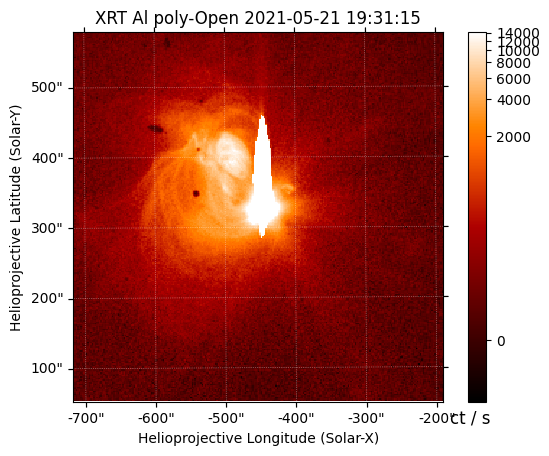

In [14]:
# total number of files downloaded using Fido
num_files = len(xrt_files_results)
print(f"Number of files downloaded: {num_files}")

# few examples of file names to understand the naming convention
print("\nSample file names:")
for file in xrt_files_results[:5]:
    print(file)

# Example of inspecting a single file from the downloaded dataset
# Here, we choose a file arbitrarily (the 85th file) for inspection
sample_file_index = 84  # Adjust the index as desired
sample_data = sunpy.map.Map(xrt_files_results[sample_file_index])

# Print information about the sample file
# This includes metadata like observation time, instrument, and data dimensions
print(f"\nSample data info for file number {sample_file_index + 1}:")
print(sample_data)

# Visualize the data from the sample file
# This step is crucial for a quick quality check and to familiarize with the data
plt.figure(figsize=(10, 8))
sample_data.peek()  # 'peek' method generates a quick-look plot of the data
plt.show()

Having successfully collected the Hinode-XRT data, we now have several exciting options at our disposal. We can analyze the FITS files to understand the solar phenomena, visualize the observations in image form ([Navigating FITS Images](#Navigating_FITS_Images)), or even create a dynamic movie ([Creating a Movie from XRT FITS Data](#Creating-a-Movie-from-XRT-FITS-Data)) showcasing a solar event. However, we can take further step towards cleaning up some of the data we have downloaded following the *Exploring Functions to Enhance Data Quality* sections bellow, which is **optional**. 

<a id="exploring-functions-to-enhance-data-quality"></a>
## Exploring Functions to Enhance Data Quality

In the following sections, I introduce a series of custom functions aimed at filtering and refining the downloaded Hinode-XRT data. These functions are designed to be user-friendly and accessible, serving as a practical toolset for both novice and experienced users. 



##### Why Enhance Data Quality?

The Sun, as observed by Hinode-XRT, presents dynamic and complex phenomena. Filtering the data helps isolate specific events or features, ensuring that subsequent analyses or visualizations focus on the most relevant and high-quality data. These enhancements are **optional** but highly recommended to achieve a clearer, more meaningful understanding of the solar data collected.


<a id="filtering-fits-files-through-selected-filter"></a>
### Filtering FITS Files Through Selected Filter

Identifying the type of data contained within Hinode XRT FITS files can be challenging, as the file titles do not provide sufficient information. To address this, I have developed a function that leverages `sunpy.map` to read the header information of each FITS file. This process allows us to identify and count the unique filters present within the dataset. 

To utilize this function, simply run the provided code in the next cell. When prompted, enter your desired filter criteria. This intuitive approach enables you to effectively narrow down your dataset to include only the most relevant observations for your analysis.

In [12]:
def normalize_string(s):
    """
    Normalize a string for comparison by converting to lowercase, replacing hyphens and underscores with spaces, and removing 'open'.
    
    Parameters:
    - s (str): The string to normalize.

    Returns:
    - str: The normalized string.
    """
    return s.lower().replace("open", "").strip("- ").replace("_", " ").replace("-", " ").strip()

## I have plans to update this function at a later time to allow users to collect FITS for more than one filter.
def filter_fits_files_by_XRT_filter(fits_files):
    """
    Filters FITS files by XRT filter criteria, accommodating flexible user input formats. It enhances readability and ensures valid input by normalizing filter names.

    Parameters:
    - fits_files (list): List of FITS file paths.

    Returns:
    - filtered_files (list): List of file paths that match the user-selected XRT channel filter.

    Raises:
    - ValueError: If the user input does not match any available filter.
    """
    measurement_info = {}

    for file_path in fits_files:
        try:
            from sunpy.map import Map
            sunpy_map = Map(file_path)
            measurement = sunpy_map.measurement
            # Normalize measurement for consistent comparison
            normalized_measurement = normalize_string(measurement)
            if normalized_measurement in measurement_info:
                measurement_info[normalized_measurement] += 1
            else:
                measurement_info[normalized_measurement] = 1
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Display available filters and their counts
    filters_output = "\n".join([f"{key.title()}: {value} files" for key, value in measurement_info.items()])
    print(f"The files have the following filters and counts:\n{filters_output}")
    filter_choice = input("Please select an XRT channel filter of interest: ")
    normalized_filter_choice = normalize_string(filter_choice)

    # Validate user input
    if normalized_filter_choice not in measurement_info:
        raise ValueError("Invalid filter choice. Please enter a valid XRT channel filter from the list provided.")

    filtered_files = []
    for file_path in fits_files:
        try:
            sunpy_map = Map(file_path)
            normalized_measurement = normalize_string(sunpy_map.measurement)
            if normalized_filter_choice in normalized_measurement:
                filtered_files.append(file_path)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    name_of_filter = filter_choice.title()
    print(f"\nFilter choice: {name_of_filter}")
    print(f"You have {len(filtered_files)} FITS files that match the '{name_of_filter}' filter.")
    print("Be sure to store this data as a new variable.")

    return filtered_files


In this example, we'll be investigating the `Al-Poly` filter on the XRT.  

In [16]:
# Assuming xrt_files_results is a list of FITS file paths
# My new variable name is reflected base on the filter of interest 
xrt_Al_poly_Obs_FITs = filter_fits_files_by_XRT_filter(xrt_files_results)


The files have the following filters and counts:
Gband: 10 files
Al Poly: 169 files
Be Thin: 163 files
Al Thick: 20 files
Be Med: 9 files
Be Thick: 9 files
Please select an XRT channel filter of interest: Al-poly

Filter choice: Al-Poly
You have 169 FITS files that match the 'Al-Poly' filter.
Be sure to store this data as a new variable.


<a id="filtering-fits-files-through-pixel-size"></a>
### Filtering FITS Files Through Pixel Size

Filtering Hinode XRT FITS files by pixel dimensions, measured in units of pixels (`pix`), is a practical approach to ensure data uniformity. We refer to these **dimensions** within the context of `sunpy.map.Map`.

XRT images typically have dimensions of `[384x384, 512x512, or 1024x1024]`, although any specific area of the CCD can be read out. For comprehensive details, please refer to the [SolarSoft XRT Analysis Guide](https://xrt.cfa.harvard.edu/resources/documents/XAG/XAG.pdf).


The function `filter_fits_files_by_XRT_dimensions` simplifies the process of selecting FITS files based on pixel dimensions. Upon running this function, you'll encounter a prompt displaying the available dimensions within your dataset. After selecting a preferred option, the function will generate a new list of FITS files filtered according to the specified dimensions. To utilize this functionality, execute the function in the cell below and follow the instructions in the subsequent steps.

In [19]:
def filter_fits_files_by_XRT_dimensions(fits_files):
    """
    Filters FITS files by their dimensions, allowing for flexible input formatting.
    Provides up to three attempts for input, with error handling for invalid formats.

    Parameters:
    - fits_files (list): List of paths to the FITS files.

    Returns:
    - A list of file paths that match the user-selected dimensions.
    """
    dimension_counts = {}
    
    # Determine the unique dimensions of all FITS files and count them
    for file_path in fits_files:
        xrt_map = sunpy.map.Map(file_path)
        # Construct a tuple for dimensions to facilitate comparison
        dimensions_tuple = (xrt_map.dimensions.x.value, xrt_map.dimensions.y.value)
        dimensions_str = f"{dimensions_tuple[0]:.0f}, {dimensions_tuple[1]:.0f}"
        dimension_counts[dimensions_str] = dimension_counts.get(dimensions_str, 0) + 1
    
    print("Unique dimensions (in pixels) found in the dataset and their counts:\n x:pix , y:pix")
    for dimensions, count in sorted(dimension_counts.items()):
        print(f"{dimensions}: {count} files")
    
    attempts = 0
    while attempts < 3:
        chosen_dimensions_str = input("\nPlease enter the dimensions of interest (e.g., '384, 384'): ")
        try:
            x_dim, y_dim = [int(dim.strip()) for dim in chosen_dimensions_str.split(',')]
            chosen_dimensions_tuple = (x_dim, y_dim)
            chosen_dimensions_str = f"{x_dim}, {y_dim}"  # Reformatted string for comparison
        except ValueError:
            print("Invalid format. Please enter dimensions in the format 'X, Y'.")
            attempts += 1
            continue
        
        # Check if the processed input matches any known dimensions
        if chosen_dimensions_str in dimension_counts:
            break  # Valid dimension found; proceed with filtering
        else:
            print(f"Error: '{chosen_dimensions_str}' is not a recognized dimension.")
            attempts += 1
    
    if attempts == 3:
        print(f"\nMaximum attempts reached. Please rerun and try again. \nIf further issues persist, please email xrtpy@cfa.harvard.edu.")
        return []

    filtered_files = []
    for file_path in fits_files:
        xrt_map = sunpy.map.Map(file_path)
        if (xrt_map.dimensions.x.value, xrt_map.dimensions.y.value) == chosen_dimensions_tuple:
            filtered_files.append(file_path)
    
    print(f"\nFound {len(filtered_files)} files matching the dimensions {chosen_dimensions_str}.")
    return filtered_files


In [21]:
# For this example, I will continue to use xrt_Al_poly_Obs_FITs. The function will prompt you to select from
# available dimensions and return a new list containing only the files that match the selected dimensions.

# Now, call the function with your list of FITS file paths:
xrt_Al_poly_384_Obs_FITs = filter_fits_files_by_XRT_dimensions(xrt_Al_poly_Obs_FITs)


Unique dimensions (in pixels) found in the dataset and their counts:
 x:pix , y:pix
256, 256: 9 files
384, 384: 160 files

Please enter the dimensions of interest (e.g., '384, 384'): 384,384

Found 160 files matching the dimensions 384, 384.


<a id="filtering-fits-files-by-exposure-time"></a>
### Filtering FITS Files by Exposure Time

Different exposure times can significantly affect the quality and the type of data captured in each image. This section introduces a method to filter your dataset based on specific exposure time criteria, allowing for a more refined and targeted analysis.

##### Why Filter by Exposure Time?

Filtering by exposure time can help isolate images that are best suited for your research goals. For instance, shorter exposure times might be preferred for studying rapid solar events, while longer exposures could provide deeper insights into fainter solar features. This flexibility ensures that you can tailor your dataset to include only the most relevant images.

##### How It Works

The `filter_fits_files_by_exposure_time` function enables you to specify criteria for selecting images based on their exposure times. You can choose to include images with an exact exposure time, those with exposure times within a specified range, or images with exposure times above or below a certain threshold. This functionality is designed to give you maximum control over the composition of your dataset.

##### Key Features:
- **Exact Match**: Retrieve images with a specific exposure time by entering the exact value in seconds.
- **Range Selection**: Specify a range of exposure times to include images that fall within this interval.
- **Above or Below a Threshold**: Filter images based on whether their exposure times are above or below a specified value.



In [24]:
def filter_fits_files_by_exposure_time(fits_files):
    """
    Filters FITS files based on exposure time criteria specified by the user.

    Parameters:
    - fits_files (list): List of FITS file paths.

    Returns:
    - List of FITS file paths that match the exposure time criteria.
    """
    exposure_time_counts = {}
    for file_path in fits_files:
        map_ = sunpy.map.Map(file_path)
        exposure_time = round(map_.exposure_time.to(u.s).value, 2)
        if exposure_time not in exposure_time_counts:
            exposure_time_counts[exposure_time] = {'count': 1, 'files': [file_path]}
        else:
            exposure_time_counts[exposure_time]['count'] += 1
            exposure_time_counts[exposure_time]['files'].append(file_path)
    
    # Display the exposure times and their counts
    print("Exposure times in the dataset (in seconds) and their counts:")
    for time, info in exposure_time_counts.items():
        print(f"{time}s: {info['count']} file(s)")

    # Prompt the user for exposure time criteria
    criteria = input("\nEnter the exposure time criteria (e.g., '0.36' for exactly 0.36s, '<1.5' for less than 1.5s, '>1.5' for more than 1.5s, '2-120' for between 2s and 120s): ")
    print("\nSelected exposure time(s):", criteria)
    # Process the user input and filter files
    filtered_files = []
    if '-' in criteria:
        lower, upper = map(float, criteria.split('-'))
        for time, info in exposure_time_counts.items():
            if lower <= time <= upper:
                filtered_files.extend(info['files'])
    elif criteria.startswith('<'):
        max_time = float(criteria[1:])
        for time, info in exposure_time_counts.items():
            if time < max_time:
                filtered_files.extend(info['files'])
    elif criteria.startswith('>'):
        min_time = float(criteria[1:])
        for time, info in exposure_time_counts.items():
            if time > min_time:
                filtered_files.extend(info['files'])
    else:
        exact_time = float(criteria)
        for time, info in exposure_time_counts.items():
            if time == exact_time:
                filtered_files.extend(info['files'])

    print(f"\nFound {len(filtered_files)} files matching the criteria.")
    return filtered_files


To use the `filter_fits_files_by_exposure_time` function, simply run the provided code with your list of FITS files. You will then be prompted to enter your exposure time criteria. The function will process your request and return a filtered list of FITS files that match your specified criteria, making it easier to proceed with a more focused analysis.

In [26]:
# In this example we're using the filtered Al-Poly Filter & 384 by 384 pixels FITS
xrt_Al_poly_384_Obs_FITs_fixed_exposure_time =filter_fits_files_by_exposure_time(xrt_Al_poly_384_Obs_FITs)

Exposure times in the dataset (in seconds) and their counts:
0.51s: 7 file(s)
0.36s: 78 file(s)
0.26s: 19 file(s)
0.18s: 14 file(s)
0.13s: 19 file(s)
0.09s: 5 file(s)
0.05s: 2 file(s)
0.04s: 4 file(s)
0.01s: 1 file(s)
0.02s: 2 file(s)
0.03s: 2 file(s)
0.06s: 4 file(s)
0.07s: 3 file(s)

Enter the exposure time criteria (e.g., '0.36' for exactly 0.36s, '<1.5' for less than 1.5s, '>1.5' for more than 1.5s, '2-120' for between 2s and 120s): 0.13-0.51
Selected exposure time(s): 0.13-0.51

Found 137 files matching the criteria.


<a id="Navigating-FITS-Images"></a>
## Navigating FITS Images 

Now, we have the capability to review images within our curated list of filtered FITS files. This enhanced navigation functionality not only facilitates sequential browsing but also introduces the ability to directly access a specific image within the dataset. Such a feature is invaluable for evaluating your dataset in detail, allowing you to identify and exclude FITS files that may not be relevant to your analysis or contain poor-quality images captured by the XRT.

Using the `view_fits_images` function, you can move forward or backward through the image dataset or jump to an Image directly navigate to a specific image by entering its number in the dataset. This feature is particularly useful when dealing with large datasets, as it enables quick access to images of interest without the need to sequentially skim through potentially hundreds of files. Whether you're looking for a particular phase of a solar event or need to examine the quality of specific images, this tool enhances your workflow by making data access more efficient and user-friendly.

In the event that you want to remove an image/FITS data set from your data. Create a list of the count number of the fits file or creating a list of string of the title name of the FITS files. This information is displayed for each image. Later we'll use functions in *[Removing Unwanted FITS Files](#Removing-unwanted-FITS-Files)* to clean out data set.

In [113]:

def view_fits_images(fits_files):
    """
    Displays FITS images one at a time with navigation buttons and an option to jump to a specific image.
    
    Parameters:
    - fits_files (list): List of paths to the FITS files.
    """
    
    current_index = [0]  # Use a list to allow modifications from inner functions
    
    def show_image(index=None):
        """Displays the image at the current index and clears the previous output."""
        if index is not None:
            # Safely update the current index based on user input
            current_index[0] = max(0, min(index, len(fits_files) - 1))
        
        clear_output(wait=True)  # Clear the previous image and controls
        display(widgets.HBox([prev_button, next_button, jump_input, jump_button]))  # Redisplay the controls
        
        fits_path = fits_files[current_index[0]]
        sunpy_map = sunpy.map.Map(fits_path)
        
        # Display FITS file name and image counter
        print(f"File: {fits_path.split('/')[-1]} (Image {current_index[0] + 1} of {len(fits_files)})")
        
        plt.figure(figsize=(6, 6))
        sunpy_map.plot()
        plt.show()
        
        update_buttons_status()
    
    def go_next(btn):
        """Go to the next image."""
        if current_index[0] < len(fits_files) - 1:
            current_index[0] += 1
            show_image()
    
    def go_prev(btn):
        """Go to the previous image."""
        if current_index[0] > 0:
            current_index[0] -= 1
            show_image()
    
    def jump_to_image(btn):
        """Jump to the image number entered by the user."""
        try:
            index = int(jump_input.value) - 1  # Convert to 0-based index
            show_image(index)
        except ValueError:
            print("Please enter a valid image number.")
    
    def update_buttons_status():
        """Updates the status of next/prev buttons based on the current index."""
        next_button.disabled = current_index[0] >= len(fits_files) - 1
        prev_button.disabled = current_index[0] <= 0
    
    # Create navigation buttons
    next_button = widgets.Button(description="Next")
    prev_button = widgets.Button(description="Previous")
    next_button.on_click(go_next)
    prev_button.on_click(go_prev)
    
    # Create jump to image widgets
    jump_input = widgets.Text(description="Jump to Image:", placeholder="Enter image number")
    jump_button = widgets.Button(description="Go")
    jump_button.on_click(jump_to_image)
    
    # Initially display buttons and the first image
    display(widgets.HBox([prev_button, next_button, jump_input, jump_button]))
    show_image()



#### Simple and Intuitive Use

1. **Navigation**: Click on the "Next" or "Previous" buttons to move through your dataset one image at a time.
2. **Direct Jump**: In the "Jump to Image" field, enter the image number you wish to view and click "Go".

The image number corresponds to its position in your list of FITS files, providing a straightforward way to access any image data directly.


File: l1_xrt20210521_235047_0.fits (Image 97 of 137)


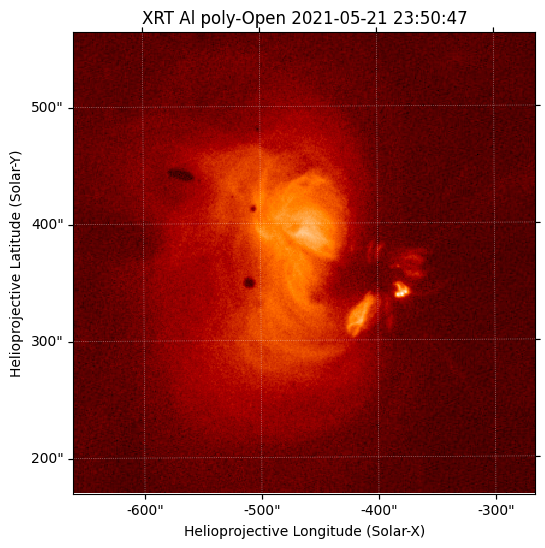

In [114]:
# We're going to use our filtered FITS data set: xrt_Al_poly_384_Obs_FITs
view_fits_images(xrt_Al_poly_384_Obs_FITs_fixed_exposure_time)

<a id="Removing-unwanted-FITS-Files"></a>
### Removing Unwanted FITS Files 


After reviewing the FITS images using the `view_fits_images` function, you may identify some images that you wish to remove from your dataset. This could be due to poor quality, irrelevance to your study, or any other reason. Below we provide a straightforward method to facilitate this, allowing you to easily remove these unwanted files from your dataset.

#### Strategy for Removal

1. **Identification**: Note down either the index number(s) or the filename(s) of the images you want to remove.
2. **Compilation**: Create a Python [list](https://docs.python.org/3/tutorial/datastructures.html) with these indices or filenames.
3. **Execution**: Use a provided function to remove these files from your dataset list.

#### Implementation

Depending on your preference for using image numbers or filenames for identification, you can use one of the two provided functions.

#### Using Image Numbers

If using index numbers to identify images, use the following function:

In [115]:
def remove_fits_by_index(original_list, indices_to_remove):
    """
    Removes FITS files from the dataset based on their index numbers.
    
    Parameters:
    - original_list (list): The original list of FITS file paths.
    - indices_to_remove (list): A list of index numbers representing the FITS files to remove.
    
    Returns:
    - A new list with the specified FITS files removed.
    """
    return [item for idx, item in enumerate(original_list) if idx not in indices_to_remove]

In [118]:
# Example list of indices to remove
indices_to_remove = [2, 5, 7]  # Based on the order in the viewing function

# New updated list
updated_index_xrt_Al_poly_384_Obs = remove_fits_by_index(xrt_Al_poly_384_Obs_FITs_fixed_exposure_time, indices_to_remove)


In [119]:

print('New length of file:',len(updated_index_xrt_Al_poly_384_Obs))

New length of file: 134


#### Using Filenames
If you prefer noting down filenames:

In [120]:
def remove_fits_by_filename(original_list, filenames_to_remove):
    """
    Removes FITS files from the dataset based on their filenames.
    
    Parameters:
    - original_list (list): The original list of FITS file paths.
    - filenames_to_remove (list): A list of filenames representing the FITS files to remove.
    
    Returns:
    - A new list with the specified FITS files removed.
    """
    return [item for item in original_list if item.split('/')[-1] not in filenames_to_remove]


In [121]:
# Example list of filenames to remove
filenames_to_remove = ['l1_xrt20210521_185300_6.fits', 'l1_xrt20210521_185720_2.fits', 'l1_xrt20210521_190120_3.fits']  # Example filenames

# New updated list
updated_FITS_xrt_Al_poly_384_Obs = remove_fits_by_filename(xrt_Al_poly_384_Obs_FITs_fixed_exposure_time, filenames_to_remove)


In [84]:
print('New length of file:',len(updated_FITS_xrt_Al_poly_384_Obs))

New length of file: 134


<a id="Creating-a-Movie-from-XRT-FITS-Data"></a>
## Visualizing Solar Dynamics: Creating a Movie from XRT FITS Data

Creating a movie from FITS files is an excellent way to visualize data, particularly for dynamic solar phenomena observed by the Hinode XRT. We can accomplish this using SunPy to handle FITS files and matplotlib, along with imageio, to create the animation.

The `create_solar_movie_from_FITS` function generates a movie (MP4 format) from the FITS files you provide. If you're interested in customizing this process, you can review and modify the function as needed. To proceed with creating a movie using the default settings, run the cell containing the function below. Then, move to the following cell for instructions on how to use this function in your workflow.

In [122]:
def create_solar_movie_from_FITS(
    fits_files, output_file="solar_movie.mp4", fps=5, processing=True
):
    """
    Creates a movie from a sequence of FITS files.

    Parameters:
    - fits_files (list): List of paths to the FITS files.
    - output_file (str): Path where the output movie will be saved.
    - fps (int): Frames per second for the output movie.
    - processing (bool): If True, prints processing messages. Default is True.
    """
    # Create a temporary directory to store the frames
    frames_dir = tempfile.mkdtemp()
    frames = []

    if processing:
        print(f"Starting to process {len(fits_files)} FITS files.\n")

    for i, file_path in enumerate(fits_files):
        if processing:
            print(f"Processing file {i+1}/{len(fits_files)}: {file_path}")
        # Load the FITS file as a SunPy Map
        xrt_map = sunpy.map.Map(file_path)

        # Plotting the SunPy Map
        fig = plt.figure(figsize=(8, 8))
        ax = plt.subplot(projection=xrt_map)
        xrt_map.plot(axes=ax)

        # Adding title and labels
        plt.title(
            f'XRT {xrt_map.measurement} {xrt_map.date.strftime("%Y-%m-%d %H:%M:%S")}'
        )
        ax.set_xlabel("Helioprojective Longitude (Solar-X)")
        ax.set_ylabel("Helioprojective Latitude (Solar-Y)")
        plt.tight_layout()

        # Saving the frame
        frame_path = os.path.join(frames_dir, f"frame_{i:04d}.png")
        plt.savefig(frame_path)
        plt.close(fig)
        frames.append(frame_path)
        if processing:
            print(f"Saved frame {i+1}/{len(fits_files)}")

    if processing:
        print("\nStarting to compile the movie.\n")

    # Compile the movie from saved frames
    with imageio.get_writer(output_file, fps=fps) as writer:
        for frame_path in frames:
            image = imageio.imread(frame_path)
            writer.append_data(image)

    # Cleanup: Remove temporary frames and directory
    for frame_path in frames:
        os.remove(frame_path)
    os.rmdir(frames_dir)

    if processing:
        print(
            f"\nMovie created: {output_file}\nAll done!\nMake sure to download the movie to your local machine to see it."
        )

In [123]:
# Specify the output file name for the movie
solar_movie_example = "solar_movie_example.mp4"

# Create the movie from the list of FITS files
# Using our Al-Poly by 384X384 filtered FITs files
create_solar_movie_from_FITS(
    xrt_Al_poly_384_Obs_FITs_fixed_exposure_time, 
    output_file=solar_movie_example, 
    fps=20, 
    processing=True
)

Starting to process 137 FITS files.

Processing file 1/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_185138_1.fits
Saved frame 1/137
Processing file 2/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_185220_1.fits
Saved frame 2/137
Processing file 3/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_185346_1.fits
Saved frame 3/137
Processing file 4/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_203810_2.fits
Saved frame 4/137
Processing file 5/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_221339_5.fits
Saved frame 5/137
Processing file 6/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_235248_0.fits
Saved frame 6/137
Processing file 7/137: /Users/jvelasq/sunpy/data/l1_xrt20210522_011843_2.fits
Saved frame 7/137
Processing file 8/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_185300_6.fits
Saved frame 8/137
Processing file 9/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_185520_2.fits
Saved frame 9/137
Processing file 10/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_185720_2.fits
Saved frame 10/137
P

Saved frame 84/137
Processing file 85/137: /Users/jvelasq/sunpy/data/l1_xrt20210522_015225_9.fits
Saved frame 85/137
Processing file 86/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_191841_1.fits
Saved frame 86/137
Processing file 87/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_192121_7.fits
Saved frame 87/137
Processing file 88/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_195104_3.fits
Saved frame 88/137
Processing file 89/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_203733_1.fits
Saved frame 89/137
Processing file 90/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_221720_2.fits
Saved frame 90/137
Processing file 91/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_222922_9.fits
Saved frame 91/137
Processing file 92/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_223321_5.fits
Saved frame 92/137
Processing file 93/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_224120_6.fits
Saved frame 93/137
Processing file 94/137: /Users/jvelasq/sunpy/data/l1_xrt20210521_224521_7.fits
Saved frame 94/137
P

In [124]:
# from IPython.display import Video

# Display the created movie within the notebook. Might to add "embed=True" to enable videos directly into a Jupyter Notebook
Video(solar_movie_example) 